In [1]:
import itertools
import math
import torch

from pathlib import Path
from PIL import Image
from torchvision import transforms

from datasets.shapenet import CLASS_DICT, ShapeNetLoader
from nerfacc.estimators.occ_grid import OccGridEstimator
from radiance_fields.ngp import NGPRadianceField
from utils import render_image_with_occgrid_test

In [2]:
device = "cuda:2"

data_root = "/media/data7/fballerini/datasets/shapenet_render"

# scene parameters
aabb = torch.tensor([-0.7, -0.7, -0.7, 0.7, 0.7, 0.7], device=device)
near_plane = 0.0
far_plane = 1.0e10
# model parameters
grid_resolution = 128
grid_nlvl = 1
# render parameters
render_n_samples = 1024
render_step_size = (
    (aabb[3:] - aabb[:3]).max() * math.sqrt(3) / render_n_samples
).item()
alpha_thre = 0.0
cone_angle = 0.0

estimator = OccGridEstimator(
    roi_aabb=aabb, 
    resolution=grid_resolution, 
    levels=grid_nlvl
).to(device)

# setup the radiance field we want to train
radiance_field = NGPRadianceField(
    aabb=estimator.aabbs[-1], 
    encoding_type="cuda"
).to(device)

In [9]:
def render(sd_path: Path, index: int = 0) -> float:
    id = f"{sd_path.parent.stem}/{sd_path.stem}"
    
    train_dataset = ShapeNetLoader(
        subject_id=id,
        root_fp=data_root,
        split="train",
        num_rays=None,
        device=device
    )
    
    sd = torch.load(sd_path)
    
    estimator.load_state_dict(sd["estimator"], strict=False)
    radiance_field.load_state_dict(sd["radiance_field"])

    # evaluation
    radiance_field.eval()
    estimator.eval()

    with torch.no_grad():
        data = train_dataset[index]
        render_bkgd = data["color_bkgd"] - 1  # white -> black
        rays = data["rays"]

        # rendering
        rgb, _, _, _ = render_image_with_occgrid_test(
            render_n_samples,
            # scene
            radiance_field,
            estimator,
            rays,
            # rendering options
            near_plane=near_plane,
            far_plane=far_plane,
            render_step_size=render_step_size,
            render_bkgd=render_bkgd,
            cone_angle=cone_angle,
            alpha_thre=alpha_thre,
        )
        
        gt = Image.open(f"{data_root}/{id}/train/{index:02}.png").convert(mode="RGB")
        rgb = transforms.ToPILImage()(rgb.permute(2,0,1))
        
        return gt, rgb

In [4]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [10]:
out_root = "/media/data2/fballerini/datasets/shapenet_render_instant"

class_path = sorted(dir for dir in Path(out_root).iterdir() if dir.stem in CLASS_DICT.keys())[-1]
sd_paths = [path for path in sorted(class_path.iterdir())][-5:]
imgs = list(itertools.chain(*[render(sd) for sd in sd_paths]))

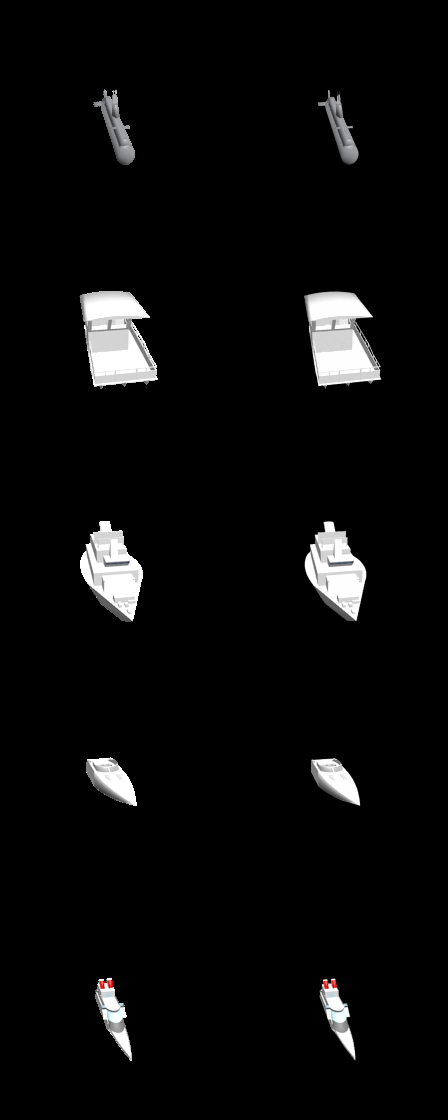

In [6]:
image_grid(imgs, rows=len(sd_paths), cols=2)

---

In [8]:
sd = torch.load(sd_paths[-1])
sd.keys()

dict_keys(['radiance_field', 'estimator', 'class_id'])

In [9]:
sd["radiance_field"]["mlp_base.0.params"].shape

torch.Size([12599920])

In [10]:
dim = 3
n_levels = 16
n_features_per_level = 2
log2_hashmap_size = 19
base_resolution = 16
finest_resolution = 4096

b = math.exp((math.log(finest_resolution) - math.log(base_resolution))/(n_levels-1))

total_size = 0

for level_idx in range(n_levels):
    resolution = math.floor(base_resolution * (b ** level_idx))
    hashmap_size = min(resolution ** dim, 2 ** log2_hashmap_size)
    
    print(f"resolution = {resolution}")
    print(f"hashmap_size = {hashmap_size}")
    print()
    
    total_size += hashmap_size * n_features_per_level
    
total_size

resolution = 16
hashmap_size = 4096

resolution = 23
hashmap_size = 12167

resolution = 33
hashmap_size = 35937

resolution = 48
hashmap_size = 110592

resolution = 70
hashmap_size = 343000

resolution = 101
hashmap_size = 524288

resolution = 147
hashmap_size = 524288

resolution = 212
hashmap_size = 524288

resolution = 307
hashmap_size = 524288

resolution = 445
hashmap_size = 524288

resolution = 645
hashmap_size = 524288

resolution = 933
hashmap_size = 524288

resolution = 1351
hashmap_size = 524288

resolution = 1955
hashmap_size = 524288

resolution = 2830
hashmap_size = 524288

resolution = 4095
hashmap_size = 524288



12545920

In [11]:
(12_599_920 - 12_545_920) / 2

27000.0